# Lab 2
## 4.1 Topological Ordering of Animal Species

In particular, your task is to write the core algorithm. Use a weight matrix of size 100 × 84 initialized with random numbers between zero and one. Use an outer loop to train the network for about 20 epochs, and an inner loop which loops through the 32 animals, one at a time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
ANIMALS = 32
DIMS = 84
HIDDEN_NODES = 100

In [3]:
def get_data(file='animals'):
    if file == 'animals':
        filename = "data/animals.dat"
        props = np.zeros((ANIMALS, DIMS))
        with open(filename) as f:
            data = f.read().split(',')
            for ndx in range(ANIMALS):
                props[ndx,:] = data[ndx*DIMS : (ndx+1)*DIMS]
        return props
        

In [4]:
def get_weights(size, sd=0.01):
    return np.random.normal(0, sd, size)

In [5]:
weights = get_weights((HIDDEN_NODES, DIMS))
props = get_data()

### SOM Algorithm
1. Calculate the similarity between the input pattern and the weights arriving at each output node.
2. Find the most similar node; *winner*
3. Select a set of output nodes which are located close to the winner *in the output grid*; *neighbourhood*.
4. Update the weights of all nodes in the neighbourhood such that their weights are moved closer to the input pattern

Make the size of the neighbourhood depend on the epoch loop variable so that you start with a neighbourhood of about 50 and end up close to one or zero.

In [6]:
def neighborhood(ndx, epoch, max_range):
    nbrhd_range = int(50 - epoch*2.5)
    nbrhd_min = np.max([0, ndx-nbrhd_range])
    nbrhd_max = np.min([max_range, ndx+nbrhd_range])
    return np.arange(nbrhd_min, nbrhd_max)

In [7]:
def train_SOM(props, weights, step_size=0.2, epochs=20, eta=0.2):
    for epoch in range(epochs):
        for animalNdx in range(ANIMALS):
            # Calculate similarity between input pattern and weights
            #  Ignore Sqrt since we only care about the winner
            similarity = np.sum(
                np.square(props[animalNdx,:]-weights), axis=1)
            # Select winner
            winner = np.argmin(similarity)
            # Update weights in neighborhood
            nbrs = neighborhood(winner, epoch, HIDDEN_NODES)
            weights[nbrs,:] = weights[nbrs,:] + \
              eta*(props[animalNdx,:] - weights[nbrs,:])
    return weights

In [8]:
w_trained = train_SOM(props, weights)

In [9]:
def get_animal_names():
    with open("data/animalnames.txt") as f:
            animals = f.read().replace("\t\n'", '')
    animals = animals.replace("\n", "").replace("''", "'").split("'")
    return animals[1:len(animals)-1]

Sort based on output nodes:
Animals next to each other in the listing should always have some similarity between them. Insects should typically be grouped together, separate from the di􏰃erent cats, for example.

In [10]:
def print_ordering(props, weights):
    pos = {}
    for animalNdx in range(ANIMALS):
        similarity = np.sum(
            np.square(props[animalNdx,:] - weights), axis=1)
        pos[animalNdx] = np.argmin(similarity)

    sorted_pos = sorted(pos.items(), key=lambda kv: kv[1])
    animal_names = get_animal_names()
    for ndx in sorted_pos:
        print(animal_names[ndx[0]])

In [11]:
print_ordering(props, w_trained)

beetle
dragonfly
grasshopper
butterfly
housefly
moskito
spider
duck
pelican
penguin
ostrich
seaturtle
frog
crocodile
walrus
bear
hyena
dog
ape
cat
lion
skunk
bat
rat
elephant
rabbit
antelop
kangaroo
horse
pig
camel
giraffe


## Prepping for 3.3, implementing Delta & Least Squares

In [190]:
# Network and data params
RBF_UNITS = 8
RBF_VAR = 2*np.pi/RBF_UNITS * 0.4550

X_MIN = 0
X_MAX = 2*np.pi

In [191]:
# Data
patterns = np.arange(0, X_MAX, 0.1)
test_set = np.arange(0.05, X_MAX, 0.1)
patterns = patterns.reshape((1, len(patterns)))
test_set = test_set.reshape((1, len(test_set)))

sin_2x = np.sin(2*patterns)
square_2x = np.square(2*patterns)

In [192]:
# Helper class for an RBF-unit
class unit:
    def __init__(self, mu, var):
        self.mu = mu
        self.var = var
        self.sd = np.sqrt(var)

In [193]:
def get_weights(size, sd=0.01):
    return np.random.normal(0, sd, size)

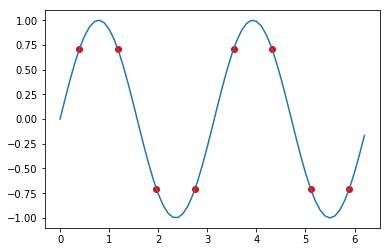

In [194]:
# Spec network
# means = np.random.choice(patterns[0,:], RBF_UNITS)
d = (X_MAX - X_MIN)/RBF_UNITS
means = np.arange(0 + d/2, X_MAX, X_MAX/RBF_UNITS)
units = [unit(means[row], RBF_VAR) for row in range(RBF_UNITS)]
weights = get_weights((RBF_UNITS, 1)).reshape((RBF_UNITS, 1))

plt.scatter(means, np.sin(2*means), c = 'r')
plt.plot(patterns.T, sin_2x.T)
plt.show()

In [195]:
# Transformation function
def phi(x, unit):
    return np.exp(-np.square((x-unit.mu)) / (2*unit.var))

def get_phi_matrix(patterns, units):
    return np.array([[phi(patterns[0,pattern_ndx], units[unit_ndx])
                    for unit_ndx in range(len(units))]
                     for pattern_ndx in range(patterns.shape[1])])

In [196]:
def least_squares_weights(phi_matrix, labels):
    return np.dot(
        np.linalg.inv(np.dot(phi_matrix.T, phi_matrix)), 
        np.dot(phi_matrix.T, labels.T))

In [197]:
def residual_error(phi_matrix, weights, labels):
    return np.mean(
        np.abs(np.dot(phi_matrix, weights) - labels.T))

In [198]:
def train_RBF_delta(patterns, units, weights, labels, learning_rate=0.15, epochs=10):
    for _ in range(epochs):
        shuffled_indices = random.sample([i for i in range(patterns.shape[1])], patterns.shape[1])
        for data_ndx in shuffled_indices:#range(patterns.shape[1]):
            # Compute Transformation function
            phi_pattern = np.array(
                [phi(patterns[0,data_ndx], unit) for unit in units]).reshape(len(units), 1)

            # Predict output
            prediction = np.dot(phi_pattern.T, weights)

            # Use instantaneous error, or derivative thereof
            # 1/2*np.square(labels[0,data_ndx] - prediction)

            dw = learning_rate*(labels[0,data_ndx] - prediction)*phi_pattern
            weights = weights + dw
    return weights

In [199]:
phi_matrix = get_phi_matrix(patterns, units)
computed_weights = least_squares_weights(phi_matrix, sin_2x)
trained_weights = train_RBF_delta(patterns, units, weights, sin_2x, epochs=20)

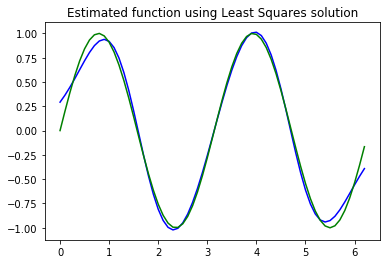

In [200]:
plt.title("Estimated function using Least Squares solution")
plt.plot(patterns[0,:], 
         np.dot(get_phi_matrix(patterns, units), computed_weights), 
         c='b')
# plt.plot(test_set[0,:], 
#          np.dot(get_phi_matrix(test_set, units), computed_weights), 
#          c='b')
# plt.plot(patterns[0,:], np.dot(get_phi_matrix(test_set, units), trained_weights), c='r')
plt.plot(patterns[0,:], sin_2x[0,:], c='g')

Residual error gets below 0.001 for 30 rbf-units, for >=35 units the error starts to increase. Variance = 0.1

In [201]:
print(residual_error(get_phi_matrix(patterns, units), trained_weights, sin_2x))
print(residual_error(get_phi_matrix(patterns, units), computed_weights, sin_2x))

0.051493951646201616
0.05398934243962457


3
7
11
15
19
23
27
31


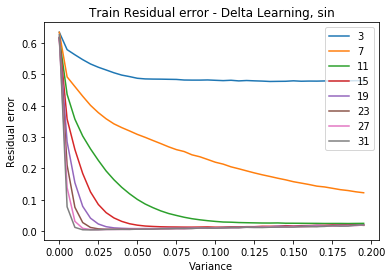

In [227]:
error_vals = {}
noise_error_vals = {}

fig = plt.figure()

for no_of_units in range(3,35, 4):
    print(no_of_units)
    RBF_UNITS = no_of_units
    for var in np.arange(0.00001, 0.2, 0.005):
        d = (X_MAX - X_MIN)/RBF_UNITS
        means = np.arange(0 + d/2, X_MAX, X_MAX/RBF_UNITS)
        units = [unit(means[row], var) for row in range(RBF_UNITS)]
        weights = get_weights((RBF_UNITS, 1)).reshape((RBF_UNITS, 1))

        phi_matrix = get_phi_matrix(patterns, units)
    #     computed_weights = least_squares_weights(phi_matrix, sin_2x)
        trained_weights = train_RBF_delta(patterns, units, weights, sin_2x, epochs=20)
        error_vals[var] = residual_error(phi_matrix, trained_weights, sin_2x)

    plt.plot(error_vals.keys(), error_vals.values(), label=str(no_of_units))
# plt.plot(noise_error_vals.keys(), noise_error_vals.values())
plt.legend()
plt.title("Train Residual error - Delta Learning, sin")
plt.xlabel("Variance")
plt.ylabel("Residual error")
fig.savefig("plot.pdf")

Train with noise

In [207]:
mean = 0
std = np.sqrt(0.1)

# Data
patterns = np.arange(0, X_MAX, 0.1)
test_set = np.arange(0.05, X_MAX, 0.1)
patterns = patterns.reshape((1, len(patterns)))
test_set = test_set.reshape((1, len(test_set)))

sin_2x_true = np.sin(2*patterns)

sin_2x_noise = np.sin(2*patterns) + np.random.normal(mean, std, patterns.shape)
square_2x_noise = np.square(2*patterns)

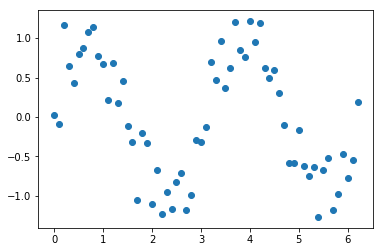

In [208]:
plt.scatter(patterns[0,:], sin_2x_noise[0,:])
# plt.scatter(patterns.T, sin_2x_true.T)

In [209]:
computed_weights = \
    train_RBF_delta(patterns, units, weights, sin_2x_noise, 0.01, 20)
print(residual_error(get_phi_matrix(patterns, units), weights, sin_2x_true))

0.6327416312312932


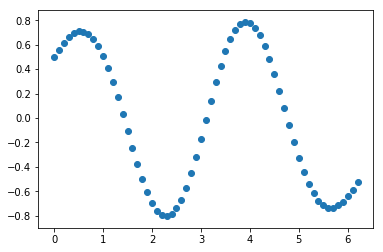

In [210]:
plt.scatter(patterns[0,:], get_phi_matrix(patterns, units).dot(computed_weights))

## 3.3 Competitive learning (CL) to initialize RBF units

In [28]:
RBF_UNITS = 14
RBF_VAR = 1 #2*np.pi/RBF_UNITS * 0.4550

X_MIN = 0
X_MAX = 2*np.pi

In [29]:
mean = 0
std = np.sqrt(0.1)

# Data
patterns = np.arange(0, X_MAX, 0.1)
test_set = np.arange(0.05, X_MAX, 0.1)
patterns = patterns.reshape((1, len(patterns)))
test_set = test_set.reshape((1, len(test_set)))

sin_2x_true = np.sin(2*patterns)

sin_2x_noise = np.sin(2*patterns) + np.random.normal(mean, std, patterns.shape)

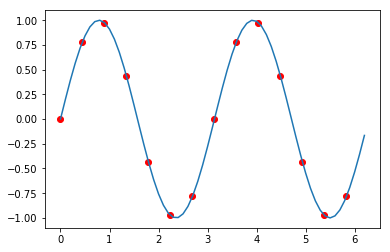

In [30]:
# Spec network
# means = np.random.choice(patterns[0,:], RBF_UNITS)
means = np.arange(0, X_MAX, X_MAX/RBF_UNITS)
units = [unit(means[row], RBF_VAR) for row in range(RBF_UNITS)]
weights = get_weights((RBF_UNITS, 1)).reshape((RBF_UNITS, 1))

plt.scatter(means, np.sin(2*means), c = 'r')
plt.plot(patterns.T, sin_2x.T)
plt.show()

In [31]:
def neighborhood(index, nbrhd_range, max_ndx, dims=1):
    if dims == 1:
        return np.arange(np.max([0, index-nbrhd_range]), np.min([max_ndx, index+nbrhd_range+1]))
    elif dims == 2:
        xs = np.arange(np.max([0, index-nbrhd_range]), np.min([max_ndx, index+nbrhd_range+1]))
        ys = np.arange(np.max([0, index-nbrhd_range]), np.min([max_ndx, index+nbrhd_range+1]))
            

In [32]:
def cl_initialize_rbf(inputs, units, iterations=1, nbrhd_range=0, eta=1):
    means = np.array([unit.mu for unit in units]).reshape((len(units), 1))
    for _ in range(iterations):
        random_indices = random.sample(range(inputs.shape[1]), inputs.shape[1])
        for ndx in random_indices:
            datapoint = inputs[0,ndx]
            
            # Calculate similarity between input pattern and weights
            #  Ignore Sqrt since we only care about the winner
            similarity = np.square(datapoint - means)
            
            # Select winner
            winner = np.argmin(similarity)
            
            # Update weights in neighborhood
            nbrs = neighborhood(winner, nbrhd_range, len(units))
            means[nbrs,:] = means[nbrs,:] + \
              eta*(datapoint - means[nbrs,:])
    
    avg_var = get_avg_var(means)
    for ndx, unit in enumerate(units):
        unit.mu = means[ndx]
        unit.var = avg_var
    return units

In [33]:
def get_avg_var(samples):
    return (np.std(samples)/2)**2

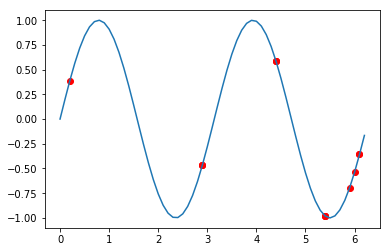

In [34]:
# Initialize rbfs using CL
cl_units = cl_initialize_rbf(patterns, units, nbrhd_range=1)

# Train network
cl_means = np.array([unit.mu for unit in cl_units])

plt.scatter(cl_means, np.sin(2*cl_means), c = 'r')
plt.plot(patterns.T, sin_2x.T)
plt.show()

## 3.3 2D

In [35]:
def get_ballist_data(test_data=False):
    filename = "data/balltest.dat" if test_data else "data/ballist.dat"
    patterns = []
    outputs = []
    with open(filename) as f:
#         print(f.readlines()[0].strip().split("\t"))
        for line in f.readlines():
            indata, outdata = line.strip().split("\t")
            angle, velocity = indata.split(" ")
            distance, height = outdata.split(" ")

            patterns.append([float(angle), float(velocity)])
            outputs.append([float(distance), float(height)])
    return np.array(patterns).T, np.array(outputs).T

In [36]:
def cl_initialize_rbf(inputs, units, iterations=1, nbrhd_range=0, eta=1, dims=2):
    means = np.array([unit.mu for unit in units]).reshape((len(units), dims))
    for _ in range(iterations):
        random_indices = random.sample(range(inputs.shape[1]), inputs.shape[1])
#         random_indices = range(inputs.shape[1])
        for ndx in random_indices:
            datapoint = inputs[:,ndx]
            
            # Calculate similarity between input pattern and weights
            #  Ignore Sqrt since we only care about the winner
            similarity = np.square(datapoint - means)
            
            # Select winner
            winner = np.argmin(similarity)
            
            # Update weights in neighborhood
            nbrs = neighborhood(winner, nbrhd_range, len(units))
            means[nbrs,:] = means[nbrs,:] + \
              eta*(datapoint - means[nbrs,:])
    
    avg_var = get_avg_var(means)
    for ndx, unit in enumerate(units):
        unit.mu = means[ndx]
        unit.var = avg_var
    return units

In [37]:
patterns, labels = get_ballist_data(test_data=False)
test_patterns, test_labels = get_ballist_data(test_data=True)

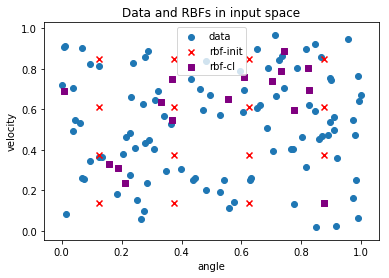

In [72]:
RBF_RbyC = 4
DIMS = 2
RBF_UNITS = RBF_RbyC**DIMS

MIN_COORDS = np.min(patterns, axis=1)
MAX_COORDS = np.max(patterns, axis=1)

# Spec network
dx = (MAX_COORDS[0] - MIN_COORDS[0])/RBF_RbyC
dy = (MAX_COORDS[1] - MIN_COORDS[1])/RBF_RbyC
xs = np.arange(MIN_COORDS[0]+dx/2, MAX_COORDS[0]+dx/2, dx)
ys = np.arange(MIN_COORDS[1]+dy/2, MAX_COORDS[1]+dy/2, dy)

xx, yy = np.meshgrid(xs, ys)

unit_means = []
for ndx in range(RBF_UNITS):
    row = int(ndx/RBF_RbyC)
    col = ndx % RBF_RbyC
    unit_means.append(np.array([xs[row], ys[col]]))

units = [unit(mean, 0) for mean in unit_means]
cl_units = cl_initialize_rbf(patterns, units, iterations=1, nbrhd_range=0, eta=0.75)
weights = get_weights((RBF_UNITS, 1)).reshape((RBF_UNITS, 1))

# [unit.mu for unit in units]
unit_means = np.array([unit.mu for unit in cl_units])

plt.scatter(patterns[0,:], patterns[1,:], label="data")
plt.scatter(xx, yy, marker='x', c='r', label="rbf-init")
plt.scatter(unit_means[:,0], unit_means[:,1], marker="s", c="purple", label="rbf-cl")
plt.title("Data and RBFs in input space")
plt.xlabel("angle")
plt.ylabel("velocity")
plt.legend()

In [73]:
def get_predictions(patterns, units, weights):
    predictions = np.zeros(patterns.shape)
    for data_ndx in range(patterns.shape[1]):
        phi_pattern = np.array([phi(patterns[:,data_ndx], unit) for unit in units]).reshape(len(units), DIMS)
        predictions[:,data_ndx] = np.dot(phi_pattern.T, weights).T
    return predictions

In [74]:
def train_RBF_delta(patterns, units, weights, labels, learning_rate=0.005, epochs=20,
                   test_pattern=None, test_labels=None, testing=False):
    mse = np.zeros((epochs, labels.shape[1]))
    if testing:
        mse_test = np.zeros((epochs, test_labels.shape[1]))
    
    for epoch in range(epochs):
        if epoch % 10 == 0:
            print("Epoch: {}".format(epoch))
        if testing:
            predictions = get_predictions(test_pattern, units, weights)
            mse_test[epoch,:] = np.sum(np.square(test_labels - predictions), axis=0)
        
        shuffled_indices = random.sample([i for i in range(patterns.shape[1])], patterns.shape[1])
        for data_ndx in shuffled_indices:#range(patterns.shape[1]):
            # Compute Transformation function
            phi_pattern = np.array(
                [phi(patterns[:,data_ndx], unit) for unit in units]).reshape(len(units), DIMS)

            # Predict output
            prediction = np.dot(phi_pattern.T, weights)
#             if epoch == epochs-1:
#                 print(prediction.T, labels[:,data_ndx])
            mse[epoch,data_ndx] = np.sum(np.square(labels[:,data_ndx] - prediction.T))
            # Use instantaneous error, or derivative thereof
            # 1/2*np.square(labels[0,data_ndx] - prediction)

            dw = learning_rate*np.dot(labels[:,data_ndx] - prediction.T, phi_pattern.T)
#             print(dw.shape)
            weights = weights + dw.T
    mse = np.mean(mse, axis=1)
    if testing:
        mse_test = np.mean(mse_test, axis=1)
        return weights, mse, mse_test
    else:
        return weights, mse

Epoch: 0
Epoch: 10


Text(0.5, 1.0, 'MSE for test and training sets during training')

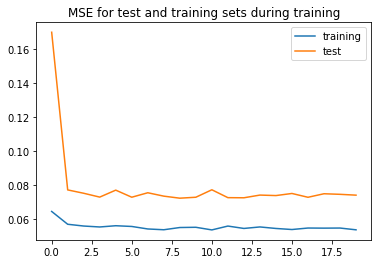

In [70]:
trained_weights, mse, mse_test = train_RBF_delta(patterns, cl_units, weights, labels, test_pattern=test_patterns, test_labels=test_labels, testing=True)
plt.plot(range(len(mse)), mse, label="training")
plt.plot(range(len(mse_test)), mse_test, label="test")
plt.legend()
plt.title("MSE for test and training sets during training")

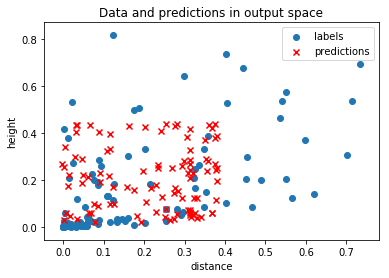

In [71]:
plt.scatter(labels[0,:], labels[1,:], label="labels")

predictions = get_predictions(patterns, cl_units, trained_weights)
# print(np.min(predictions[0,:]), np.max(predictions[1,:]))
# print(np.min(labels[0,:]), np.max(labels[1,:]))
plt.scatter(predictions[0,:], predictions[1,:], marker="x", c="r", label="predictions")
plt.title("Data and predictions in output space")
plt.xlabel("distance")
plt.ylabel("height")
plt.legend()

# SLP

In [228]:
def get_weights(size):
    return np.random.normal(0, 0.001, size)

In [ ]:
def train_slp(patterns, targets, 
                       epochs=EPOCHS,
                       learning_rate=ETA,
                       multipleTraining=1):
    accs = []
    for _ in range(multipleTraining):
        
        
        weights = get_weights()
        
        for epoch in range(epochs):
            dw = -learning_rate*np.dot(np.dot(weights, pattern) - targets, pattern.T)
            weights = weights + dw
            if compute_accuracy(weights, pattern, targets) == 1.0:
                print("Learning converged after {} epochs".format(epoch))
                break
        accs.append(compute_accuracy(weights, fullPattern, fullTargets))

    if multipleTraining == 1:

        print("Accuracy: {}".format(compute_accuracy(weights, pattern, targets)))
        print("MSE: {}".format(compute_error(weights, pattern, targets)))

        print(weights)
    else:
        return accs
